# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [2]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF
import seaborn as sns

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

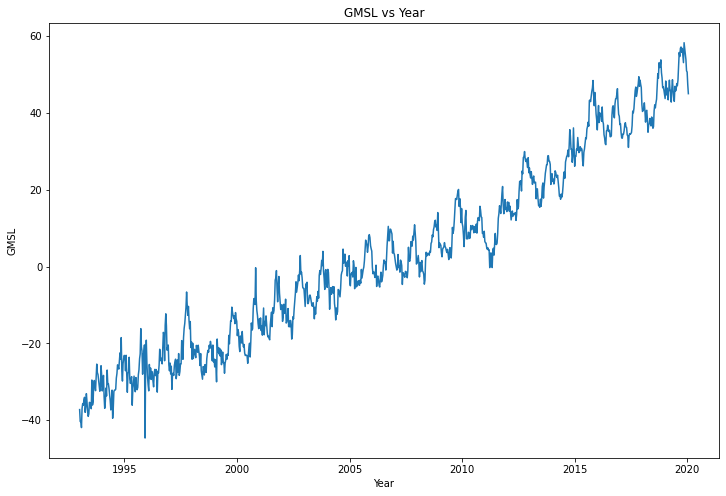

In [3]:
plt.figure(figsize=(12,8))
sealevel = pandas.read_csv("sealevel.csv")
plt.plot(sealevel["Year"],sealevel["GMSL"])
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('GMSL vs Year')
plt.show()

In [4]:
print("There are {} observations in total in this data set".format(sealevel.shape[0]))

There are 997 observations in total in this data set


**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:**

According to the assumption of AR, the data modelled should be weakly stationary, including the condition that mean value is const. So the trend needs to be removed

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

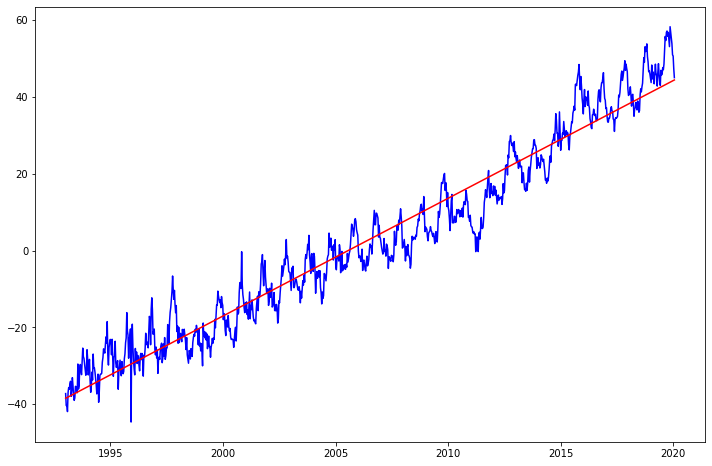

In [5]:
plt.figure(figsize=(12,8))
AR2 = lm.LinearRegression().fit(sealevel[["Year"]],sealevel[["GMSL"]])
y_pred = AR2.predict(sealevel[["Year"]])
plt.plot(sealevel[["Year"]],sealevel[["GMSL"]],color = 'blue')
plt.plot(sealevel[["Year"]],y_pred,color = 'red')

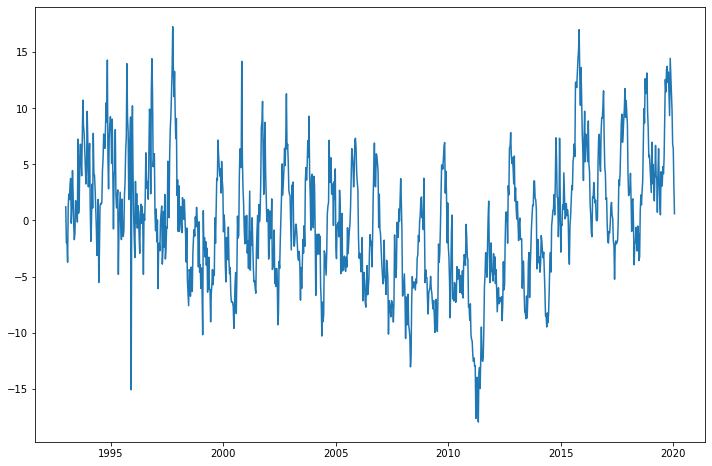

In [49]:
plt.figure(figsize=(12,8))
plt.plot(sealevel[["Year"]],sealevel[["GMSL"]]-y_pred)

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

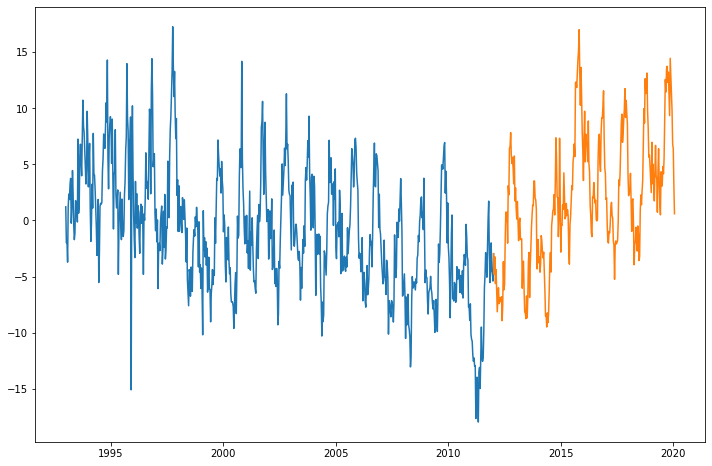

In [50]:
sealevel_new = pandas.DataFrame({"Year":[],"GMSL":[]})
sealevel_new["Year"] = sealevel["Year"]
sealevel_new["GMSL"] = sealevel[["GMSL"]]-y_pred
train = sealevel_new.loc[0:700]
valid = sealevel_new.loc[700:,]
plt.figure(figsize=(12,8))
plt.plot(train["Year"],train["GMSL"])
plt.plot(valid["Year"],valid["GMSL"])

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

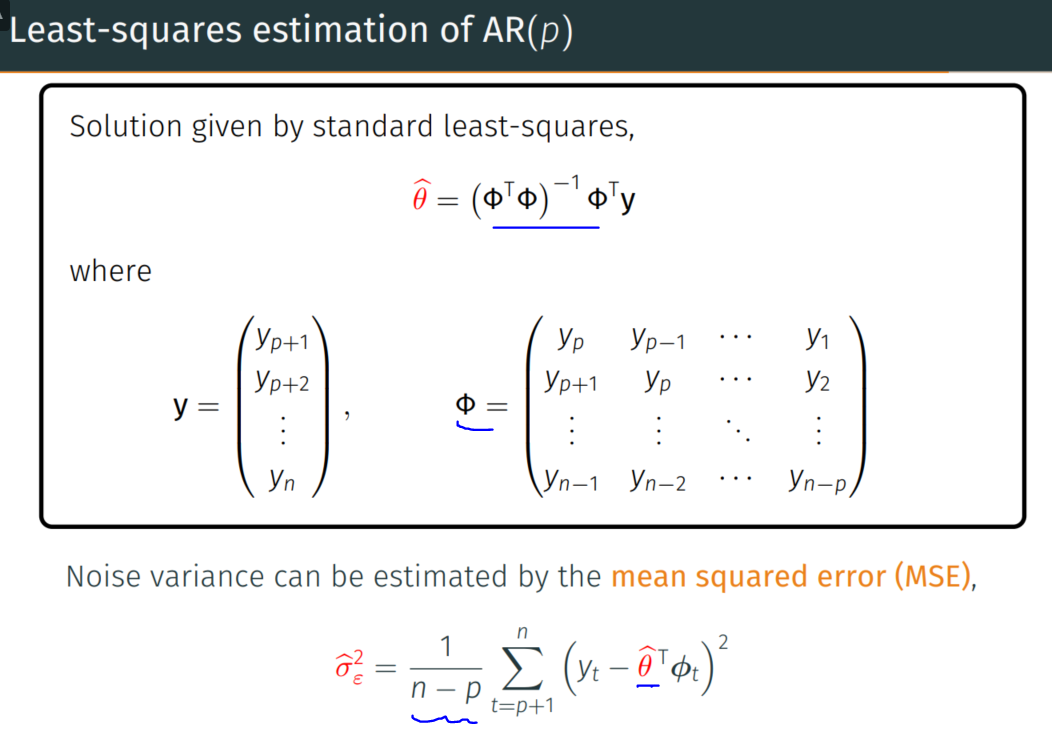

In [51]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y) 
    
    # Construct the regression matrix
    Phi = np.zeros((n-p,p))
    for j in range(p):
        Phi[:,j] = y.loc[j:n+j-p-1]   # for p-order, from t-p to t-1, otherwise, near AR(1), the closest one
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [52]:
theta = fit_ar(train["GMSL"], 10)
print(theta)

[ 0.02260504 -0.11141565  0.07678916 -0.09605165 -0.06010635 -0.02226543
  0.17512341  0.15071884  0.10788555  0.62126167]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [53]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(n)
    
    for i in range(n):
        if i < p:
            y_pred[i] = y_target[i]
            pass
        else:
            y_pred[i] = np.dot(a = theta.T, b= y_target[i-p:i])
            pass
        pass
    return y_pred

In [54]:
train_pred = predict_ar_1step(theta, np.array(train["GMSL"], np.float64))
valid_pred = predict_ar_1step(theta, np.array(valid["GMSL"], np.float64))

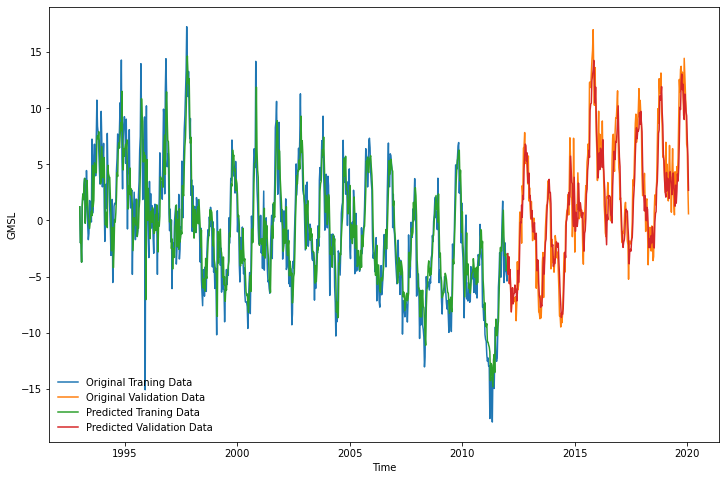

In [55]:
plt.figure(figsize=(12,8))
plt.plot(train["Year"],train["GMSL"], label = "Original Traning Data")
plt.plot(valid["Year"],valid["GMSL"], label = "Original Validation Data")
plt.plot((train["Year"]),train_pred, label = "Predicted Traning Data")
plt.plot((valid["Year"]),valid_pred, label = "Predicted Validation Data")
plt.xlabel("Time")
plt.ylabel('GMSL')
plt.legend(loc='lower left', frameon=False)

<AxesSubplot:ylabel='Density'>

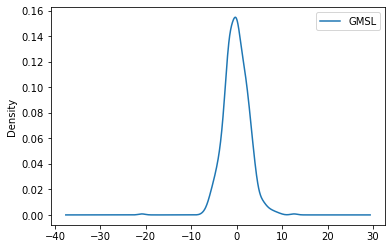

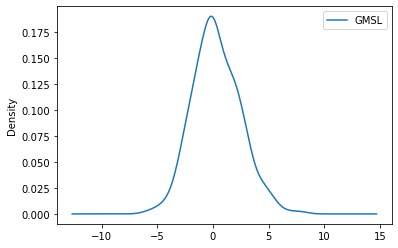

In [56]:
#plt.subplot(211)
train_residual = ((train["GMSL"]) - train_pred)
pandas.DataFrame(train_residual).plot(kind='density')
#plt.subplot(212)
valid_residual = ((valid["GMSL"]) - valid_pred)
pandas.DataFrame(valid_residual).plot(kind='density')


**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

In [57]:
help(acfplot)

Help on function acfplot in module tssltools_lab1:

acfplot(x, lags=None, conf=0.95)
    Plots the empirical autocorralation function.
    
    :param x: array (n,), sequence of data points
    :param lags: int, maximum lag to compute the ACF for. If None, this is set to n-1. Default is None.
    :param conf: float, number in the interval [0,1] which specifies the confidence level (based on a central limit
                 theorem under a white noise assumption) for two dashed lines drawn in the plot. Default is 0.95.
    :return:



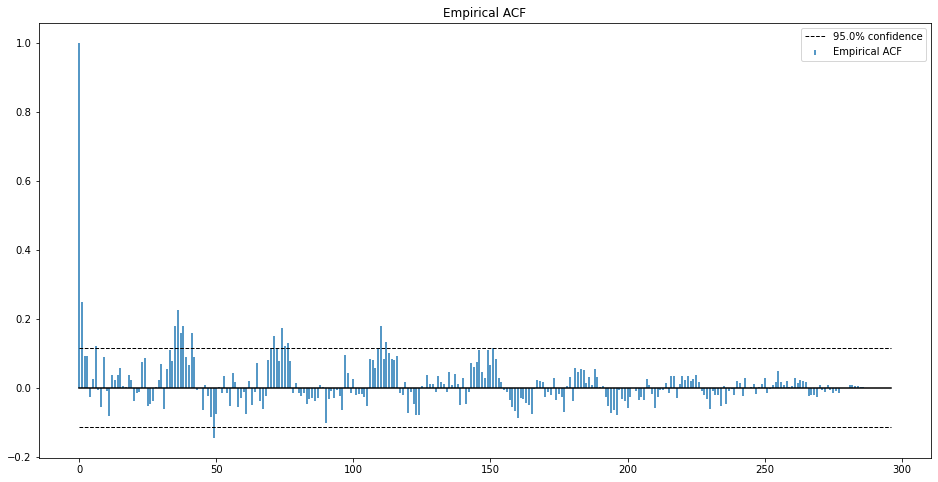

In [58]:
plt.figure(figsize=(16,8))
acfplot(valid_residual)

According to the assumption of AR model, the absolute value of ACF should consistently/monotonously decrease with lag's increasing, but here  it has some significant fluctuations, which indicates some far points in time still have bigger influence than the some near poins. So the p value for AR(p) may be not so proper.  

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

What is the main difference between the changes in training error and validation error as the order increases?
Based on these results, which model order would you suggest to use and why?**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [59]:
list_of_p = (range(2,151))
train_mse = []
valid_mse = []

for p in list_of_p:
    theta = fit_ar(train["GMSL"],p)
    train_pred = predict_ar_1step(theta, np.array(train["GMSL"], np.float64))
    train_mse.append(np.sum((train["GMSL"] - train_pred)**2)/(len(train["GMSL"]) - len(theta)))
    valid_pred = predict_ar_1step(theta, np.array(valid["GMSL"], np.float64))
    valid_mse.append(np.sum((valid["GMSL"] - valid_pred)**2)/(len(valid["GMSL"]) - len(theta)))

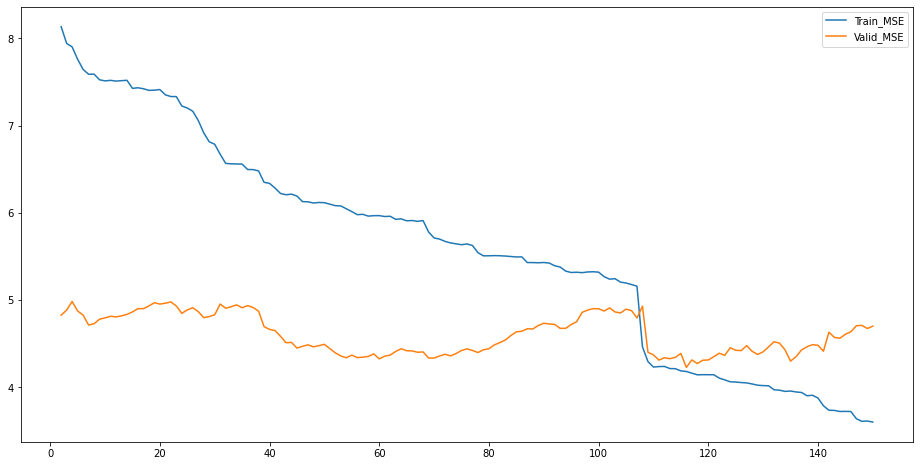

In [60]:
plt.figure(figsize=(16,8))
plt.plot(list_of_p,train_mse,label = 'Train_MSE')
plt.plot(list_of_p,valid_mse,label = 'Valid_MSE')
plt.legend()

In [61]:
valid_mse[0:100].index(min(valid_mse[0:100]))

58

**What is the main difference between the changes in training error and validation error as the order increases?**

According to the plot above, the main difference is that the training error decreases with the increase of order, but the validation error stays stable with some kind of bias, but there is an increasing trend when the order is between 60 and 108 but goes back to the normal situation after it.

**Based on these results, which model order would you suggest to use and why?**

Based on these results, we suggest using the P = 58, in which the training error is the lowest when it is still higher than the validation error, in this case, it is the boundary of the over-fitting, which means the lowest error.

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

In [28]:
theta = fit_ar(train["GMSL"], 58)
valid_pred = predict_ar_1step(theta, np.array(valid["GMSL"], np.float64))

<AxesSubplot:ylabel='Density'>

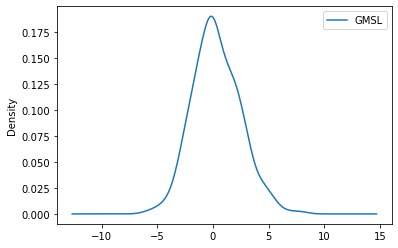

In [29]:
valid_residual_n = ((valid["GMSL"]) - valid_pred)
pandas.DataFrame(valid_residual).plot(kind='density')

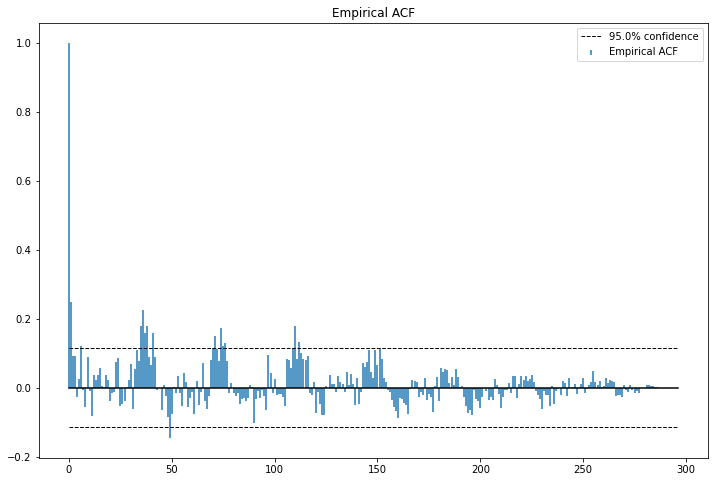

In [30]:
plt.figure(figsize=(12,8))
acfplot(valid_residual)

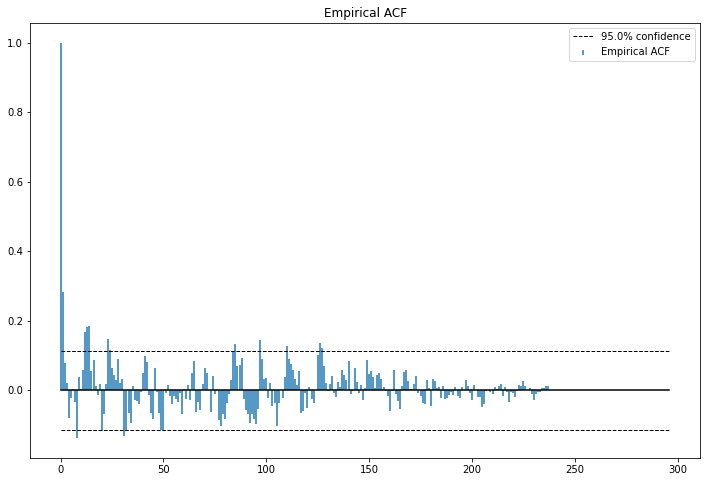

In [31]:
plt.figure(figsize=(12,8))
acfplot(valid_residual_n)

**What conclusions can you draw?**

By comparing the plots above, we could find that the residual with higher p=107 gets to 0, which is the mean of the data, more quickly than the P = 10. In this case, the higher order p could help AR model becomes convergence more quickly.

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [32]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    theta = np.flip(theta.copy())
    for i in range(m):
        y_sim[i] = np.dot(a = phi, b= theta)
        phi = np.append(y_sim[i],phi[:len(phi)-1])
    return y_sim
    

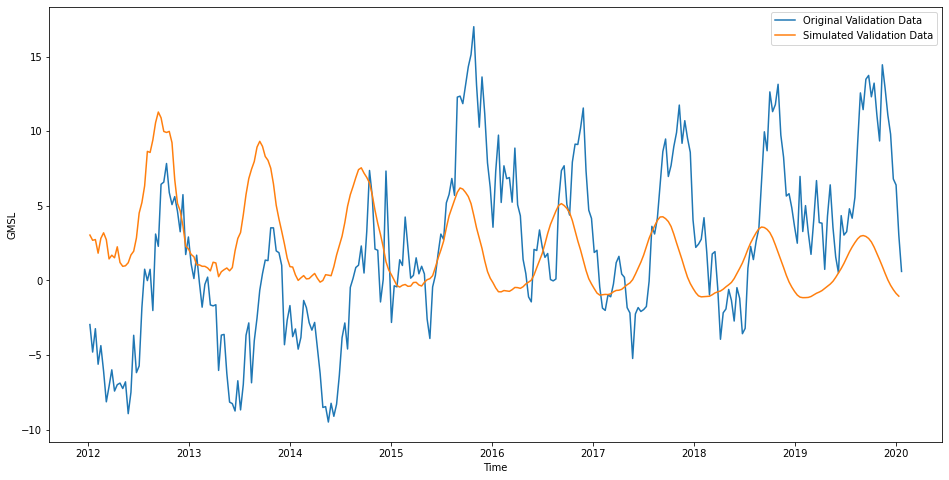

In [33]:
theta_1 = fit_ar(y = train['GMSL'] , p = 58)

y_sim_pred_valid = simulate_ar(y = valid['GMSL'] , theta = theta_1 , m = len(sealevel) - len(train['GMSL']))

plt.figure(figsize=(16,8))
plt.plot(valid['Year'] , valid['GMSL'] , label = "Original Validation Data")
plt.plot(valid['Year'][:-1] , y_sim_pred_valid , label = "Simulated Validation Data")
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

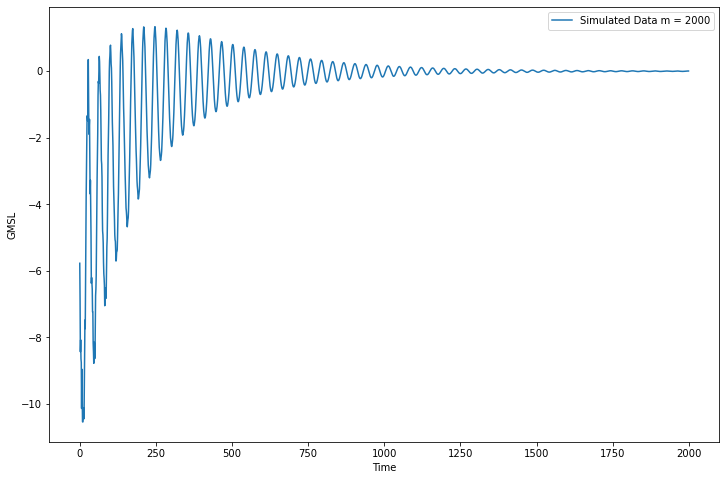

In [34]:
theta = fit_ar(train['GMSL'], 58)
sim = simulate_ar(train['GMSL'] ,theta , 2000)
plt.figure(figsize=(12,8))
plt.plot(range(2000) , sim , label = "Simulated Data m = 2000")
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()
plt.show()

**Is this something that you would expect to see in general? Explain the result.**

all the data have the expectation of zero value, and all the predicted data have the 0-expectation too, so when m tend to be a quite large number, the corresponding predicted values are tended to be zero value(due to mean reversion)

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [35]:
def Phi_get(y , p):
    n = y.shape[0]
    Phi = np.zeros((n-p,p), dtype= float)
    for j in range(p):
        Phi[:,j] = y[j:(n+j-p)]
    return Phi

p = 58
yModel = train["GMSL"][p:]  

model = MLPRegressor(hidden_layer_sizes=(10,) , activation= "relu",max_iter=2000)
reg = model.fit(Phi_get(y = train["GMSL"] , p = p), yModel)
n = train["GMSL"].shape[0]
dataValid_Y = np.append(train["GMSL"][(n - p): ] , valid["GMSL"])
predictedVal = reg.predict(Phi_get(y = dataValid_Y , p = p))

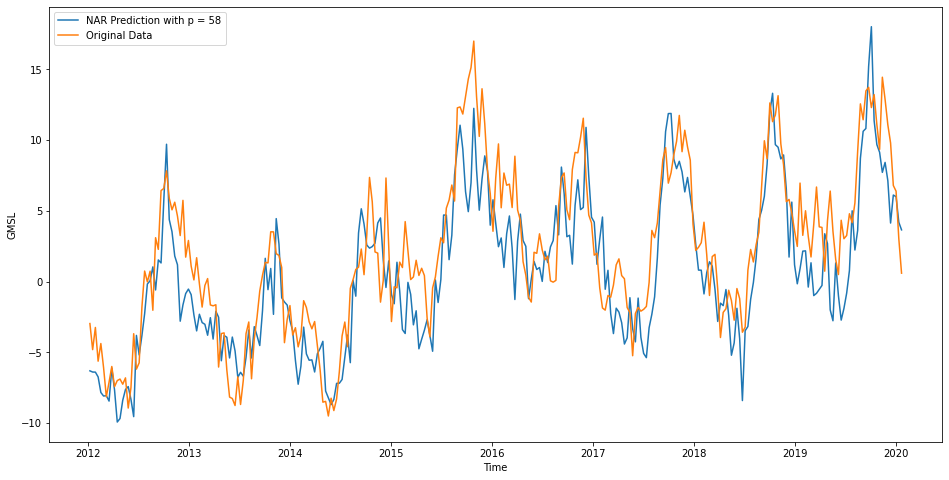

In [36]:
plt.figure(figsize=(16,8))
plt.plot(valid['Year'] , predictedVal , label = "NAR Prediction with p = "+str(p))
plt.plot(valid['Year'] , valid["GMSL"] , label = "Original Data")
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

In this part, we change some arguments and get some acceptable results(not bad). As to the limitations, they should be the complexities brought by NAR, for instance, what non-linear function to choose, what structure to use, how to optimize computational complexity, how to better maintain the complex models,and so on...

**A13:**

In [38]:
model = MLPRegressor(hidden_layer_sizes=(10,) , activation= "tanh",max_iter=2000)
reg = model.fit(Phi_get(y = train["GMSL"] , p = p), yModel)
n = train["GMSL"].shape[0]
dataValid_Y = np.append(train["GMSL"][(n - p): ] , valid["GMSL"])
predictedVal = reg.predict(Phi_get(y = dataValid_Y , p = p))

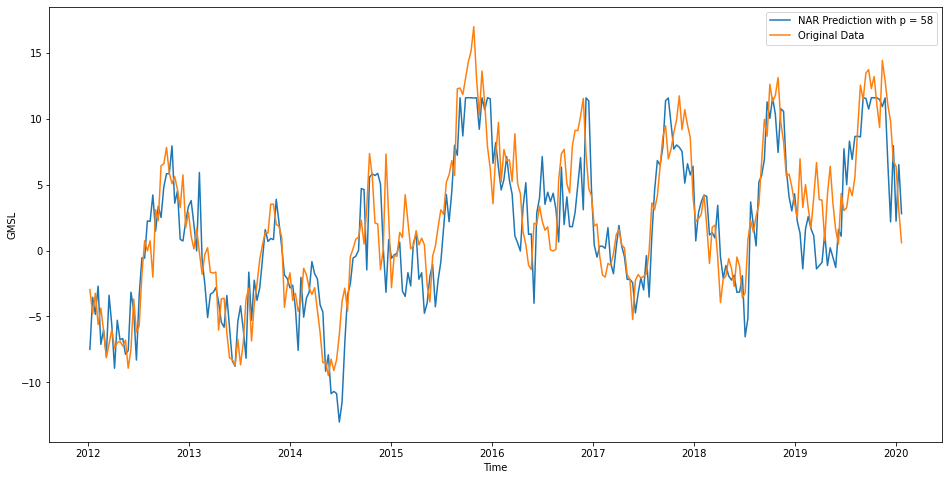

In [39]:
plt.figure(figsize=(16,8))
plt.plot(valid['Year'] , predictedVal , label = "NAR Prediction with p = "+str(p))
plt.plot(valid['Year'] , valid["GMSL"] , label = "Original Data")
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()

In [43]:
model = MLPRegressor(hidden_layer_sizes=(10,) , activation= "relu",momentum=0.6,max_iter=3000)
reg = model.fit(Phi_get(y = train["GMSL"] , p = p), yModel)
n = train["GMSL"].shape[0]
dataValid_Y = np.append(train["GMSL"][(n - p): ] , valid["GMSL"])
predictedVal = reg.predict(Phi_get(y = dataValid_Y , p = p))

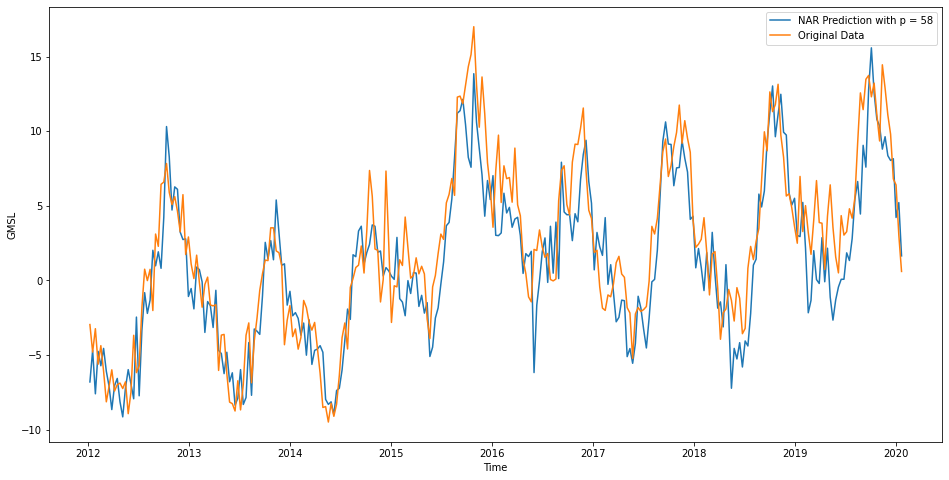

In [44]:
plt.figure(figsize=(16,8))
plt.plot(valid['Year'] , predictedVal , label = "NAR Prediction with p = "+str(p))
plt.plot(valid['Year'] , valid["GMSL"] , label = "Original Data")
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.legend()